In [2]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

#from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [3]:
#computer vision library
# torch vision
# torch vision. datasets
#torchvision.models
# torchvision.transfors(img -> torch data)
#torch.utils.data.dataset
#torch.utils.data.dataloader

import torch
from torch import nn


import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt



dataset : FASHIONMNIST

In [4]:
#setup training data
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root='./data',   # where to download the data to
    train=True,     # this is training dataset
    download=True,  # do we want to download
    transform= torchvision.transforms.ToTensor(),   # how do we wan to transform the data img-> tensor
    target_transform=None  # how do we want to transform the labels/targets?
)

test_data = datasets.FashionMNIST(
    root='./data',   # where to download the data to
    train=False,     # this is training dataset
    download=True,  # do we want to download
    transform= ToTensor(),   # how do we wan to transform the data img-> tensor
    target_transform=None  # how do we want to transform the labels/targets?
)

In [5]:
image , label = train_data[0]
len(test_data)
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [6]:
class_name = train_data.classes
class_name

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
image.shape, label

(torch.Size([1, 28, 28]), 9)

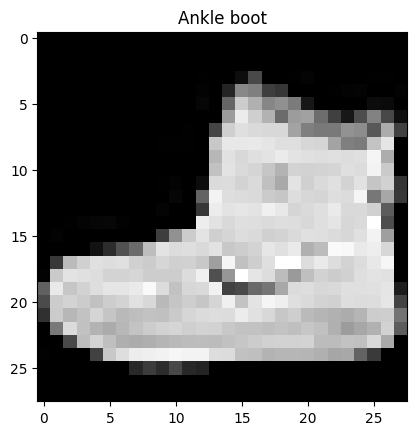

In [8]:

# visualize the data
plt.title(class_name[label])
plt.imshow(image.squeeze(),cmap="gray")

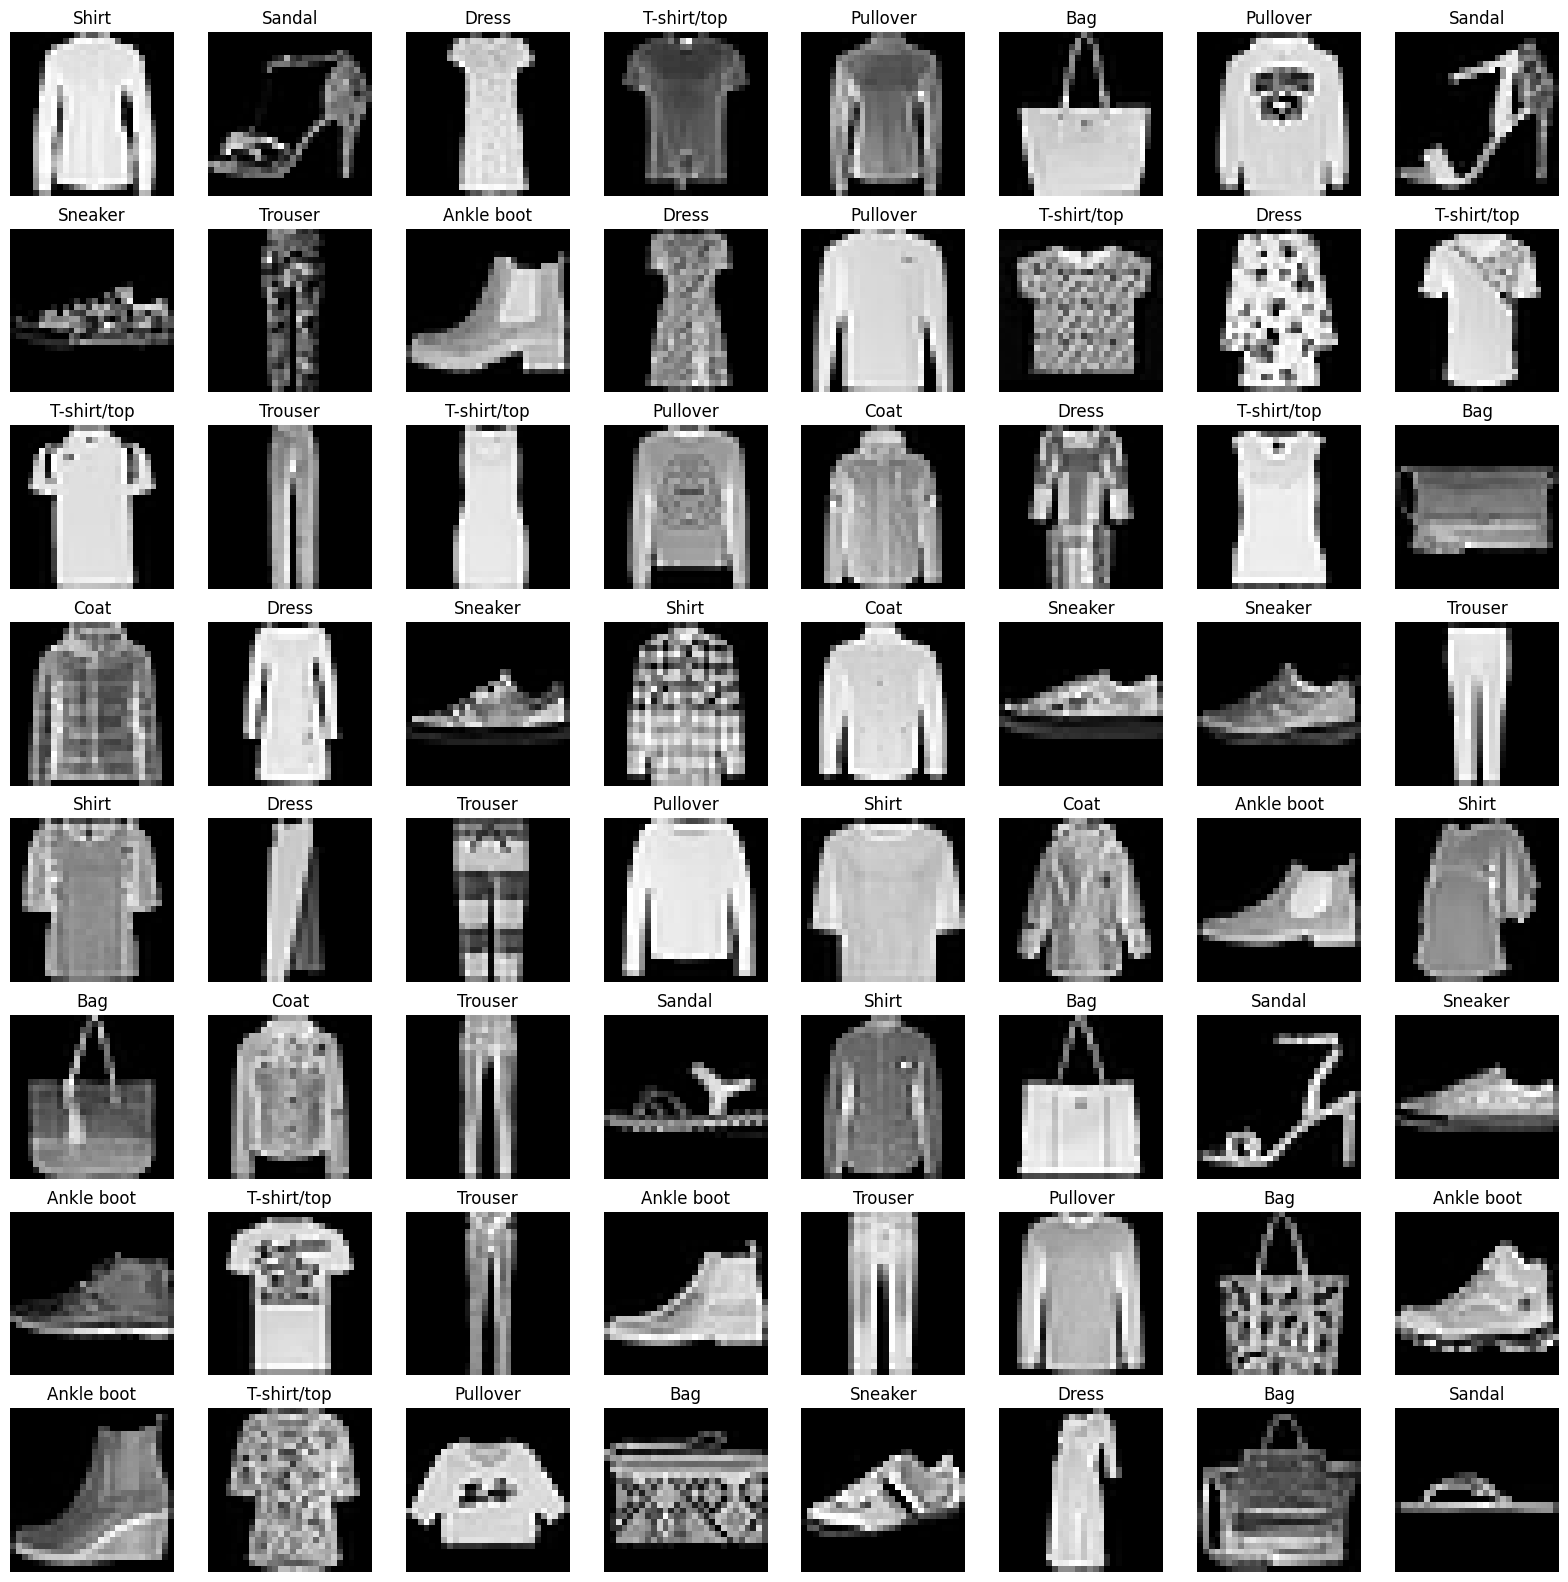

In [9]:
#torch.manual_seed(42)
fig = plt.figure(figsize=(20,20))
row,column = 8,8
for i in range(1,row*column+1):
    random_indx = torch.randint(0,len(train_data),size=[1]).item()
    img, label = train_data[random_indx]
    fig.add_subplot(row,column,i)
    plt.imshow(img.squeeze(),cmap = "gray")
    plt.title(class_name[label])
    plt.axis(False)

In [10]:
# now the data is in form of Pytorch Datasets, DataLoader turns our dataset into a python iterable 
# we want to make the batches 
# more effective way to seprate in between in the batches (32)
# it gives our neural network more chance to update its gradient per epoch

from torch.utils.data import DataLoader

#setup the batch size
BATCH_SIZE = 32

#turn the datasets to iterable batches
train_dataloader = DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

In [11]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [12]:
# basline model : start simple and add complexity
# create a flatten layer
flatten_model = nn.Flatten()

# get a single example
x = train_features_batch[0]

#flatten the sample
output = flatten_model(x)

print(x.shape)
print(output.shape)
output.squeeze()

torch.Size([1, 28, 28])
torch.Size([1, 784])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [13]:
from torch import nn

class fashion_mist(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape),
            nn.ReLU()
        )

    def forward(self,x):
        return self.layer_stack(x)
    


In [14]:

#by convonutional neural network
class fashion_mist_v2(nn.Module):
    """replicting the TinyVGG model from CNN explainer website"""

    def __init__(self, Input_shape: int, Hidden_units: int, Output_shape:int):
        super().__init__()
        ##feature extractor layers
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=Input_shape,
                      out_channels=Hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1), # hyper hyperparameter which can be changed 
            nn.ReLU(),
            nn.Conv2d(in_channels=Hidden_units,
                      out_channels=Hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=Hidden_units,
                      out_channels=Hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=Hidden_units,
                      out_channels=Hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=Hidden_units*7*7,
                      out_features=Output_shape)

        )

    def forward(self,x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        return self.classifier(x)

In [15]:
torch.manual_seed(42)
model_1 = fashion_mist_v2(Input_shape=1, Hidden_units= 10 , Output_shape = len(class_name))
model_1.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

In [16]:
torch.manual_seed(42)

#setup model with input parameters
model_0 = fashion_mist(input_shape=784,hidden_units=10,output_shape=len(class_name))
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.3.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

In [17]:
#setup loss function and optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [18]:
#training model
#optimizer will update the data per batch not per epoch
# loop through testing batches
#printout what happening

##tqdm library for progress bar
from tqdm.auto import tqdm
from IPython.display import clear_output

torch.manual_seed(42)

#select epoch values
epochs = 5

#creating training and test loop
for epoch in tqdm(range(epochs)):
    #clear_output(wait=False)
    print(f"Epoch: {epoch}\n-----")
    
    #training starts
    train_loss = 0

    #add loop to loop through the training batches
    for batch, (X_train,Y_train) in enumerate(train_dataloader):
        model_1.train()
        #print("Input shape:", X_train.shape)

        #forward pass
        y_preds = model_1(X_train)
        #print("Output shape:", y_preds.shape)

        #calculate loss(per batch)
        loss = loss_fn(y_preds,Y_train)

        #accumulate train losss
        train_loss += loss

        #optimizer zero grad
        optimizer.zero_grad()

        #loss backward
        loss.backward()

        # optimizer step
        optimizer.step()

        if batch % 400 ==0:
            print(f"Looked at {batch*len(X_train)}/{len(train_dataloader.dataset)} samples.")

    #divide total train loss by length of train data loader
    train_loss /= len(train_dataloader)

    ##testing loop

    test_loss, test_acc = 0, 0
    model_1.eval()
    with torch.inference_mode():
        for x_test, y_test in test_dataloader:
            # forward pass
            test_pred = model_1(x_test)

            #caluclate the loss(accumulatively)
            #
            test_loss += loss_fn(test_pred,y_test)

            # calculate accuracy
            test_acc += accuracy_fn(y_true= y_test, y_pred = test_pred.argmax(dim=1)) #logits to the arguments

        #clculate test loss
        test_loss /= len(test_dataloader)

        #calculate accuracy
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss : {train_loss:.4f} | Test loss : {test_loss:.4f} | Test accuracy : {test_acc:.4f}")

    






C:\Users\abhishek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 20%|██        | 1/5 [00:30<02:03, 30.83s/it]


Train loss : 0.5876 | Test loss : 0.3899 | Test accuracy : 85.9924
Epoch: 1
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 40%|████      | 2/5 [01:01<01:31, 30.62s/it]


Train loss : 0.3612 | Test loss : 0.3565 | Test accuracy : 86.6314
Epoch: 2
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 60%|██████    | 3/5 [01:30<01:00, 30.19s/it]


Train loss : 0.3249 | Test loss : 0.3271 | Test accuracy : 87.9692
Epoch: 3
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 80%|████████  | 4/5 [02:04<00:31, 31.48s/it]


Train loss : 0.3044 | Test loss : 0.3280 | Test accuracy : 87.8494
Epoch: 4
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|██████████| 5/5 [02:33<00:00, 30.74s/it]


Train loss : 0.2916 | Test loss : 0.3089 | Test accuracy : 89.0176


In [19]:
device = "cpu"

In [20]:
def make_prediction(model: torch.nn.Module,
                    data: list,
                    device: torch.device = device):
    """Make prediction using trained model on given input data."""
    pred_prob = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            #prepare the sample add a batch dimension and pass t target device
            sample = torch.unsqueeze(sample,dim=0).to(device)
            #forward pass model output raw logits
            pred_logit = model(sample)
            #get prediction probablity logits to prediction probablity
            pred_probs = torch.softmax(pred_logit.squeeze(),dim=0)
            #get pred_rob off the gpu for further calculation
            pred_prob.append(pred_probs.cpu())
    return torch.stack(pred_prob)
        

In [21]:
img, label = test_data[0][:10]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [22]:
import random
random.seed(40)
test_sample = []
test_label = []
for sample,label in random.sample(list(test_data),k=9):
    test_sample.append(sample)
    test_label.append(label)

In [23]:
# make prediction
pred_probs = make_prediction(model=model_1,
                             data=test_sample)
#convert prediction probablity to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes,test_label

(tensor([8, 0, 9, 8, 0, 4, 0, 5, 7]), [8, 0, 9, 8, 0, 4, 0, 5, 7])

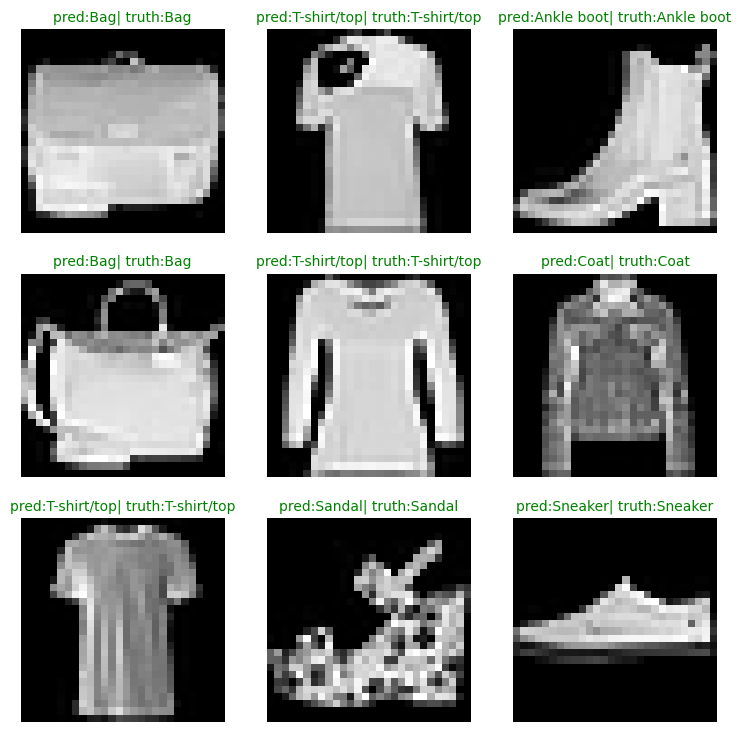

In [24]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i,sample in enumerate(test_sample):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(sample.squeeze(),cmap="gray")
    pred_label = class_name[pred_classes[i]]
    truth_label = class_name[test_label[i]]
    title_text = f"pred:{pred_label}| truth:{truth_label}"

    if pred_label == truth_label:
        plt.title(title_text,fontsize= 10,c='g')
    else:
        plt.title(title_text, color='r',fontsize=10)
    plt.axis(False)


In [25]:
#confusion matrix
y_preds = []
model_1.eval()
with torch.inference_mode():
    for x, y in tqdm( test_dataloader,desc= "MAKING PREDICTION.."):
        #do forward pass
        y_logits = model_1(x)
        #logits->prediction probablity->prediction label
        y_pred = torch.softmax(y_logits.squeeze(),dim=0).argmax(dim=1)
        #put prediction on CPu for evaluation
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

MAKING PREDICTION..: 100%|██████████| 313/313 [00:02<00:00, 140.32it/s]


tensor([9, 2, 1,  ..., 8, 1, 2])

In [27]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#confusion matrix instance and compare prediction to target
confmat = ConfusionMatrix(num_classes= len(class_name))
confmat_tensor = confmat(preds= y_pred_tensor,
                         targets= test_data.targets)

#plot matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),class_names=class_name,figsize=(10,7))


TypeError: __new__() missing 1 required positional argument: 'task'